In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.mpc.mpc_run import MPC
from core.mpc.mpc_params import MPCParams
from core.mpc.mpc_bounds import ControlInputBounds

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting import *

## Model Parameters

In [2]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 0.1,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = False,
    verbose          = True
)

In [3]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [4]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [5]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [6]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## MPC params and bounds

In [7]:
mpc_params = MPCParams(
    solver          = "ipopt",
    solver_options  = {
        "tol": 1e-4,          # looser tolerance than default 1e-8
        "max_iter": 500,      # limit iterations so it doesn't grind forever
        "print_level": 5,     # moderate verbosity
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    },
    reoptimization_interval=5
)
bounds = ControlInputBounds()

## Input Disturbances

In [8]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [9]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(),
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Plot disturbances

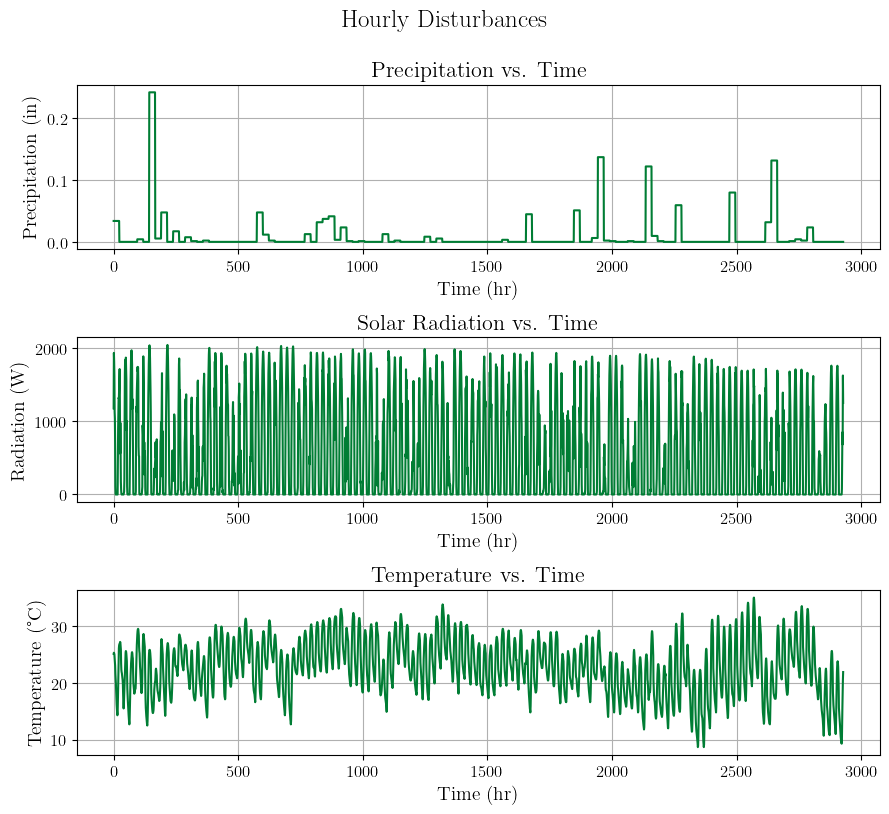

In [10]:
plot_hourly_inputs(
    input_disturbances
)

In [11]:
# Convert inputs from hourly to simulation time steps
from core.model.model_helpers import get_sim_inputs_from_hourly
simulation_hours = len(input_disturbances.precipitation)
temperature   = get_sim_inputs_from_hourly(input_disturbances.temperature,   model_params.dt, simulation_hours, mode='split')
radiation     = get_sim_inputs_from_hourly(input_disturbances.radiation,     model_params.dt, simulation_hours, mode='split')
precipitation = get_sim_inputs_from_hourly(input_disturbances.precipitation, model_params.dt, simulation_hours, mode='split')

## Optimal/Typical Values

In [12]:
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

## Simulation of Plant Growth over Season

In [13]:
# Construct an instance of the Member class and get the cost
mpc = MPC(
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    mpc_params           = mpc_params,
    bounds               = bounds
)

In [14]:
mpc_result = mpc.run()

Step 0/29000
[CFTOC] Solver status: ok, termination: optimal
Step 1/29000
Step 2/29000
Step 3/29000
Step 4/29000
Step 5/29000
WARNING (W1002): Setting Var 'uW[0]' to a numeric value
`-7.862791949402152e-09` outside the bounds (0.0, 10.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'uF[0]' to a numeric value
`-7.862792004664275e-09` outside the bounds (0.0, 500.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'uW[1]' to a numeric value
`-7.862791949402152e-09` outside the bounds (0.0, 10.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'uF[1]' to a numeric value
`-7.862792004664275e-09` outside the bounds (0.0, 500.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'uW[2]' to a numeric value
`-7.862791949402152e-09` outside the bounds (0.0, 10.0).
    See also https://pyomo.

In [15]:
h = mpc_result["h"]
A = mpc_result["A"]
N = mpc_result["N"]
c = mpc_result["c"]
P = mpc_result["P"]

irrigation = mpc_result["uW"]
fertilizer = mpc_result["uF"]

delayed_water = mpc_result["logs"]["delayed_water"]
delayed_fertilizer = mpc_result["logs"]["delayed_fertilizer"]
delayed_temperature = mpc_result["logs"]["delayed_temperature"]
delayed_radiation = mpc_result["logs"]["delayed_radiation"]

cumulative_water = mpc_result["logs"]["cumulative_water"]
cumulative_fertilizer = mpc_result["logs"]["cumulative_fertilizer"]
cumulative_temperature = mpc_result["logs"]["cumulative_temperature"]
cumulative_radiation = mpc_result["logs"]["cumulative_radiation"]

delta_cumulative_water = mpc_result["logs"]["delta_cumulative_water"]
delta_cumulative_fertilizer = mpc_result["logs"]["delta_cumulative_fertilizer"]
delta_cumulative_temperature = mpc_result["logs"]["delta_cumulative_temperature"]
delta_cumulative_radiation = mpc_result["logs"]["delta_cumulative_radiation"]

nuWs = mpc_result["logs"]["nuW"]
nuFs = mpc_result["logs"]["nuF"]
nuTs = mpc_result["logs"]["nuR"]
nuRs = mpc_result["logs"]["nuT"]

## Plot crop growth results

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:205: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:213: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

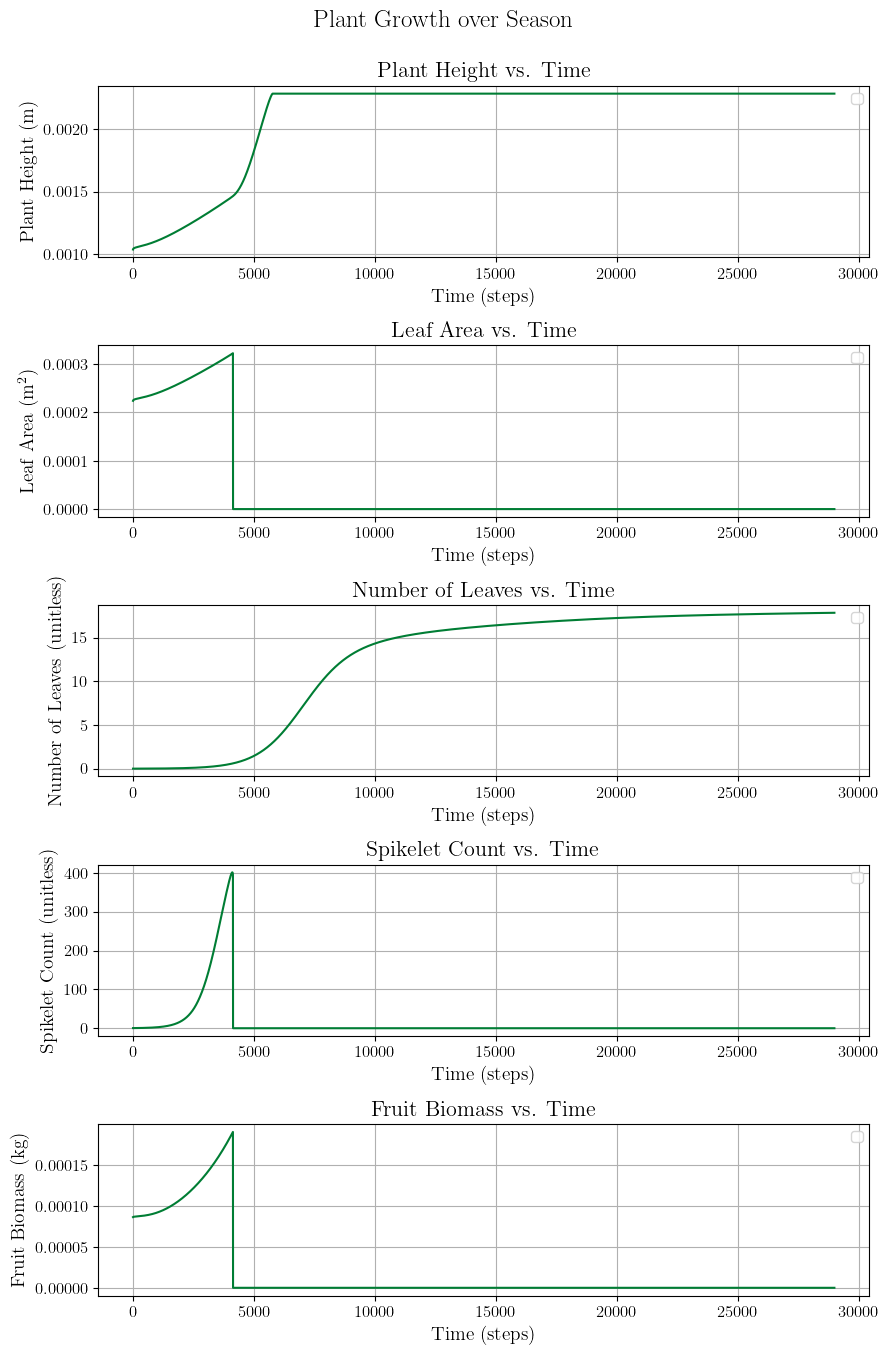

In [16]:
plot_crop_growth_results(
    hs = [h],
    As = [A],
    Ns = [N],
    cs = [c],
    Ps = [P]
)

In [17]:
profit = mpc_params.weight_fruit_biomass * P[-1]
expenses = (mpc_params.weight_irrigation * np.sum(irrigation)
            + mpc_params.weight_fertilizer * np.sum(fertilizer))
revenue = profit - expenses

print(f'weight_fruit_biomass: {mpc_params.weight_fruit_biomass}')
print(f'weight_irrigation: {mpc_params.weight_irrigation}')
print(f'weight_fertilizer: {mpc_params.weight_fertilizer}')
print(f'Fruit biomass: {P[-1]}')

print(f'\n')

print(f'Profit: ${profit:.2f}')
print(f'Irrigation used (in): {np.sum(irrigation):.2f}, irrigation expense: ${mpc_params.weight_irrigation * np.sum(irrigation):.2f}')
print(f'Fertilizer used (lbs): {np.sum(fertilizer):.2f}, fertilizer expense: ${mpc_params.weight_fertilizer * np.sum(fertilizer):.2f}')
print(f'Expenses: ${expenses:.2f}')
print(f'Revenue: ${revenue:.2f}')

weight_fruit_biomass: 4450
weight_irrigation: 2.0
weight_fertilizer: 0.614
Fruit biomass: 0.0


Profit: $0.00
Irrigation used (in): 249.57, irrigation expense: $499.14
Fertilizer used (lbs): 2688.48, fertilizer expense: $1650.72
Expenses: $2149.87
Revenue: $-2149.87


## Plot input and disturbance evolution with delays taken into account

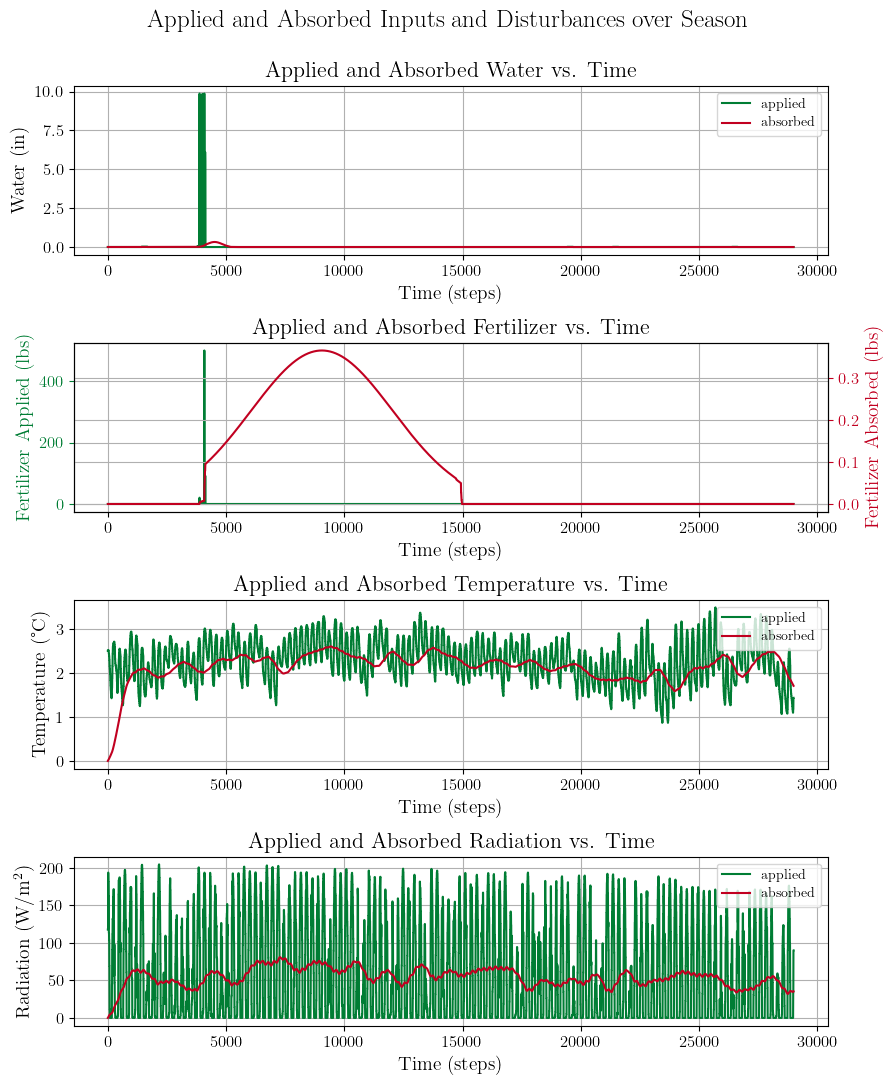

In [18]:
plot_applied_vs_absorbed(
        irrigation,
        precipitation[0:len(irrigation)],
        delayed_water,
        fertilizer,
        delayed_fertilizer,
        temperature[0:len(irrigation)],
        delayed_temperature,
        radiation[0:len(irrigation)],
        delayed_radiation
)

## Plot cumulative value evolution

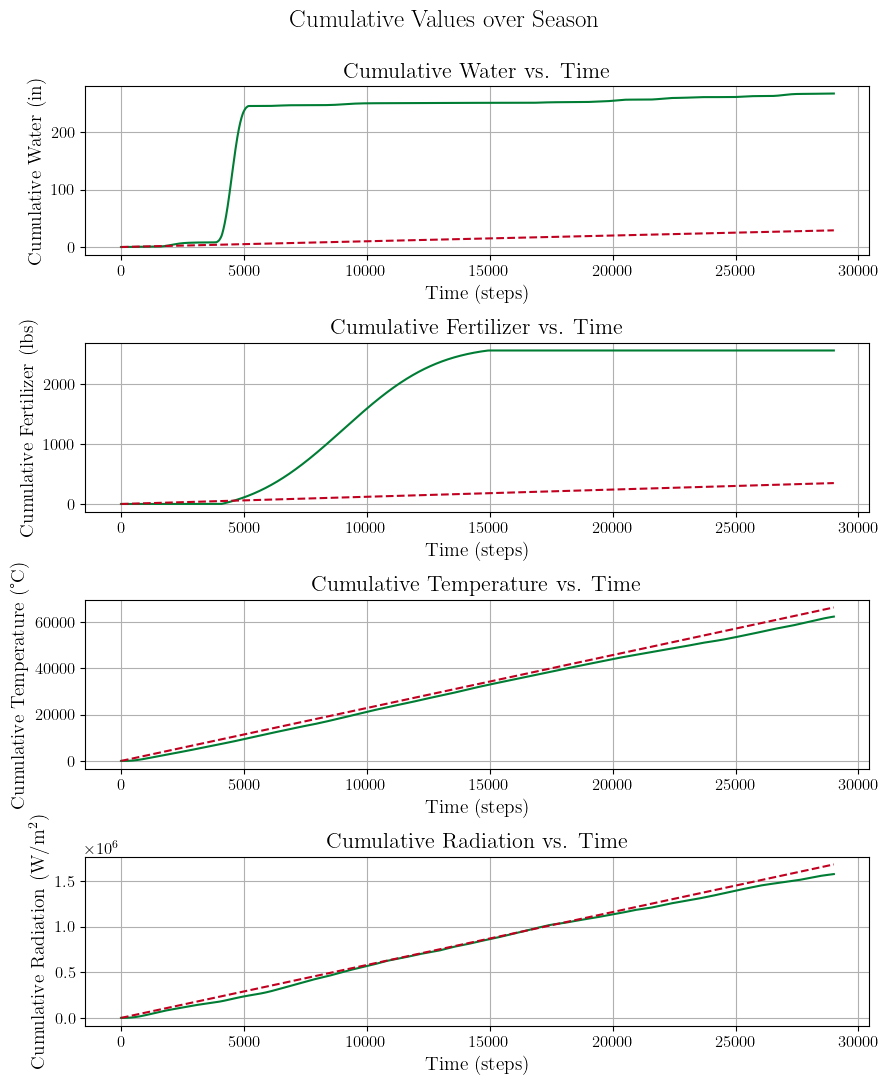

In [19]:
plot_cumulative_values(
    cumulative_water,
    cumulative_fertilizer,
    cumulative_temperature,
    cumulative_radiation,
    typical_disturbances
)

## Plot the deltas between actual and expected cumulative value

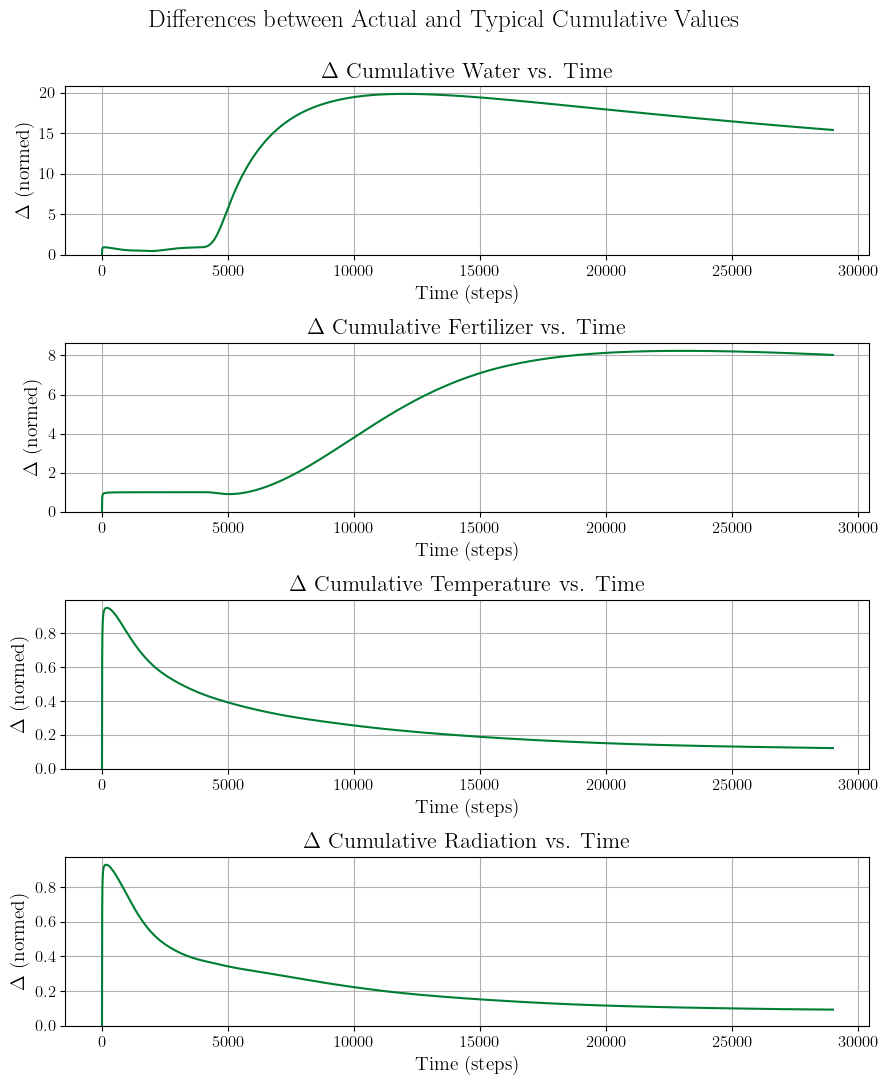

In [20]:
plot_actual_vs_expected_cumulatives(
    delta_cumulative_water,
    delta_cumulative_fertilizer,
    delta_cumulative_temperature,
    delta_cumulative_radiation
)

## Plot nutrient factor evolution

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:513: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:523: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:533: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

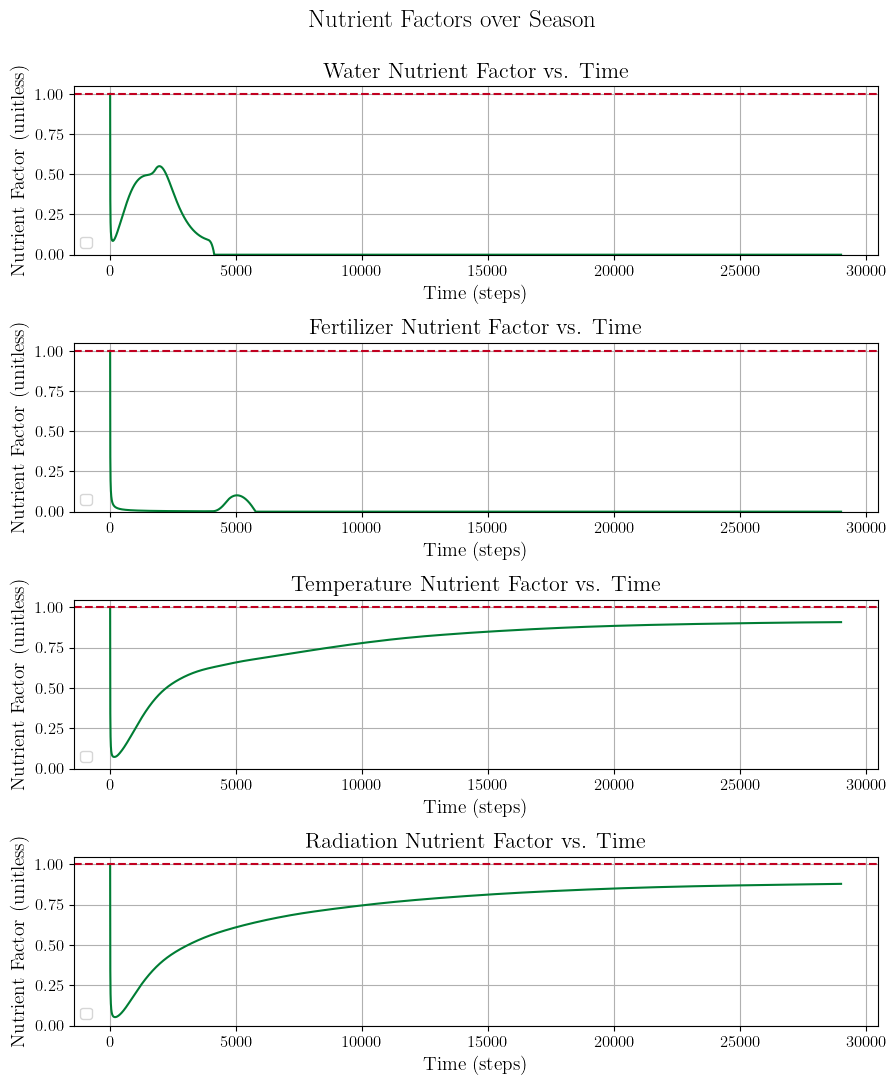

In [21]:
plot_nutrient_factor_evolution(
    [nuWs],
    [nuFs],
    [nuTs],
    [nuRs]
)

## Plot growth rates over time

In [22]:
plot_growth_rate_evolution(
        growth_rates,
        [ah_hat],
        [aA_hat],
        [aN_hat],
        [ac_hat],
        [aP_hat],
)

NameError: name 'ah_hat' is not defined

## Plot carrying capacities over time

In [ ]:
plot_carrying_capacity_evolution(
        carrying_capacities,
        [kh_hat],
        [kA_hat],
        [kN_hat],
        [kc_hat],
        [kP_hat]
)